# Knight Online Item-Class Analiz

Bu notebook, portfolyo için sadeleştirilmiş sürümdür. Gereksiz tekrarlar ve deneme hücreleri çıkarıldı. Önemli çıktılar bırakıldı, uzun metin çıktıları temizlendi.
Local'de postgresql'e bağlanarak analiz yapıldı. Analiz 14 bin item üzerinden gerçekleştirilmiştir.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Grafiklerin anında görüntülenmesi için
%matplotlib inline


In [ ]:
from sqlalchemy import create_engine

# PostgreSQL bağlantısı (SQLAlchemy formatında)
engine = create_engine("....")

query = "SELECT * FROM items"
items_df = pd.read_sql(query, engine)

items_df.head()


,id,name,class,category,features,description
0,1,Iron Bow (+1),Rogue,Normal,"[Attack Power : 93, Effective Range : 40, Weig...",NaN
1,2,Iron Bow (+2),Rogue,Normal,"[Attack Power : 97, Effective Range : 40, Weig...",NaN
2,3,Iron Bow (+3),Rogue,Normal,"[Attack Power : 101, Effective Range : 40, Wei...",NaN
3,4,Iron Bow (+4),Rogue,Normal,"[Attack Power : 105, Effective Range : 40, Wei...",NaN
4,5,Iron Bow (+5),Rogue,Normal,"[Attack Power : 109, Effective Range : 40, Wei...",NaN


Veri Keşfi

In [ ]:
#Satır ve Sütun sayısı:

items_df.shape

(14416, 6)

In [ ]:
items_df.columns #sütun adları

Index(['id', 'name', 'class', 'category', 'features', 'description'], dtype='object')

In [ ]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14416 entries, 0 to 14415
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           14416 non-null  int64 
 1   name         14416 non-null  object
 2   class        14416 non-null  object
 3   category     14416 non-null  object
 4   features     14416 non-null  object
 5   description  14416 non-null  object
dtypes: int64(1), object(5)
memory usage: 675.9+ KB


In [ ]:
items_df.isnull().sum()

id             0
name           0
class          0
category       0
features       0
description    0
dtype: int64

In [ ]:
items_df["features"].head(10)

0    [Attack Power : 93, Effective Range : 40, Weig...
1    [Attack Power : 97, Effective Range : 40, Weig...
2    [Attack Power : 101, Effective Range : 40, Wei...
3    [Attack Power : 105, Effective Range : 40, Wei...
4    [Attack Power : 109, Effective Range : 40, Wei...
5    [Attack Power : 113, Effective Range : 40, Wei...
6    [Attack Power : 119, Effective Range : 40, Wei...
7    [Attack Power : 128, Effective Range : 40, Wei...
8    [Attack Power : 141, Effective Range : 40, Wei...
9    [Attack Power : 161, Effective Range : 40, Wei...
Name: features, dtype: object

In [ ]:
# Sadece string olanlara işlem yapıyoruz, Database'de veriler Jsonb type olarak tutulmuştu( Web scraping yaparken daha kolay yöntem buydu) Bu yüzden buradaki veriler value, key olarak ayırdım. Sonrasında sütunlara ayıracağız..
items_df["features"] = items_df["features"].apply(lambda x: x.strip("[]") if isinstance(x, str) else x)


In [ ]:
items_df["features"] = items_df["features"].apply(
    lambda x: x.strip("[]") if isinstance(x, str) else x
    
)

In [ ]:
features_expanded = items_df["features"].apply(
    lambda x: x.split(",") if isinstance(x, str) else []
)


In [ ]:
features_df = pd.DataFrame(features_expanded.tolist())


In [ ]:
# key- value formatından sadece value kısmını alıyoruz
for col in features_df.columns:
    features_df[col] = features_df[col].apply(
        lambda x: x.split(":")[1].strip() if isinstance(x, str) and ":" in x else None
    )


In [ ]:
features_df = features_df.apply(pd.to_numeric, errors="coerce")


In [ ]:
import re

# Tüm item özellikleri key-value olarak topluyoruz
parsed_features = []
all_keys = set()

for row in items_df["features"]:
    feature_dict = {}
    if isinstance(row, list):
        # her bir eleman için
        for part in row:
            # bir itemin birden fazla özelliği olabilir, boşlukla ayrılmış olarak veriliyor data'da. Onları da yakalıyoruz.
            matches = re.findall(r"([A-Za-z\s]+)\s*:\s*([\d]+)", part)
            for key, value in matches:
                key_clean = key.strip()
                feature_dict[key_clean] = int(value)
                all_keys.add(key_clean)
    parsed_features.append(feature_dict)

# Tüm key'leri sütun'a dönüştürüyoruz
features_df = pd.DataFrame(parsed_features)

# Database'deki veriyi bozmadan analiz df oluşturuyoruz
items_analysis_df = pd.concat([items_df.copy(), features_df], axis=1)

items_analysis_df.head()


In [ ]:
# çıkan tabloda description sütunu sürekli NaN bilgisi taşıyor, aslında bu sütuna ihtiyacımız yok.
items_analysis_df = items_analysis_df.drop(columns=["features", "description"])
items_analysis_df.head()


Veri Analizi

In [ ]:
# Sınıflar listesi
valid_classes = ["Warrior", "Rogue", "Mage", "Priest", "Kurian"]

# Sadece geçerli sınıfları tut
items_analysis_df = items_analysis_df[items_analysis_df["class"].isin(valid_classes)]

# Temizlenmiş veri, hangi sınıfta kaç farklı item var?
class_counts_clean = items_analysis_df["class"].value_counts()

print("Temizlenmiş Sınıf Bazlı Item Sayıları:")
print(class_counts_clean)


Temizlenmiş Sınıf Bazlı Item Sayıları:
class
Warrior    6485
Rogue      2929
Mage       2906
Priest     1572
Kurian      474
Name: count, dtype: int64


In [ ]:
#Sınıfa göre ortalama Attack Power

class_attack_avg = items_analysis_df.groupby("class")["Attack Power"].mean().sort_values(ascending=False)

print("\nSınıf Bazlı Ortalama Attack Power:")
print(class_attack_avg)


Sınıf Bazlı Ortalama Attack Power:
class
Kurian     198.871951
Warrior    145.289788
Mage       129.235620
Rogue      120.608317
Priest     115.185567
Name: Attack Power, dtype: float64


In [ ]:
#Sınıfa göre ortalama Defense Ability

if "Defense Ability" in items_analysis_df.columns:
    class_defense_avg = items_analysis_df.groupby("class")["Defense Ability"].mean().sort_values(ascending=False)
    print("\nSınıf Bazlı Ortalama Defense Ability:")
    print(class_defense_avg)
else:
    print("\n'’Defense Ability’ kolonu bulunamadı.")


Sınıf Bazlı Ortalama Defense Ability:
class
Kurian     148.070968
Priest     112.815593
Rogue       97.628830
Warrior     97.415179
Mage        77.203789
Name: Defense Ability, dtype: float64


In [ ]:
# Her kategorinin oranını bul
category_ratio = items_analysis_df["category"].value_counts(normalize=True) * 100

print("Kategori Oranları (%):")
print(category_ratio)


Kategori Oranları (%):
category
Reverse    55.332034
Normal     42.969511
Rare        1.698455
Name: proportion, dtype: float64


In [ ]:
#Kategorilere göre Attack Power
category_attack_avg = items_analysis_df.groupby("category")["Attack Power"].mean().sort_values(ascending=False)

print("\nKategorilere Göre Ortalama Attack Power:")
print(category_attack_avg)



Kategorilere Göre Ortalama Attack Power:
category
Reverse    148.523319
Normal     120.815299
Rare        83.109244
Name: Attack Power, dtype: float64


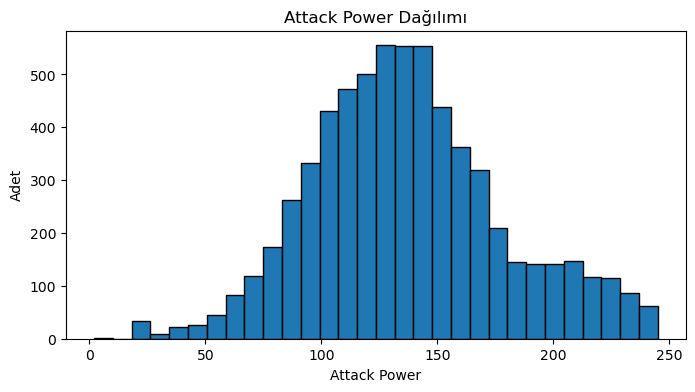

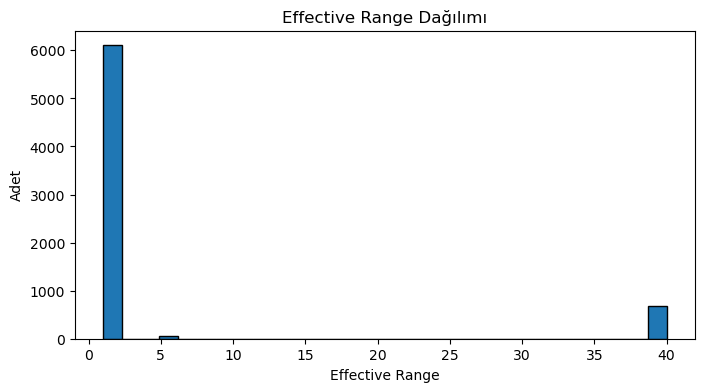

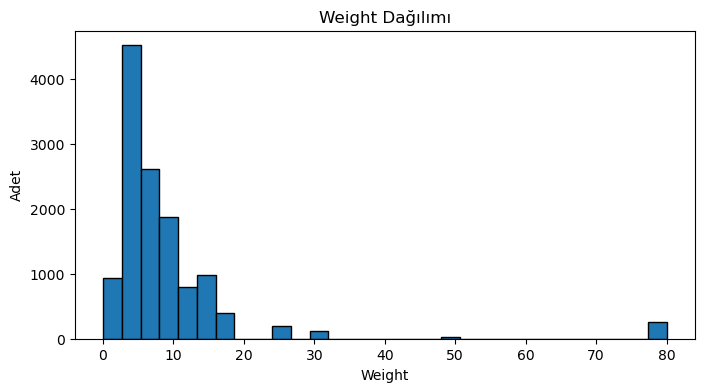

In [ ]:
import matplotlib.pyplot as plt

# Analiz edeceğimiz sayısal kolonlar
numeric_cols = ["Attack Power", "Effective Range", "Weight"]

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    plt.hist(items_analysis_df[col].dropna(), bins=30, edgecolor='black')
    plt.title(f"{col} Dağılımı")
    plt.xlabel(col)
    plt.ylabel("Adet")
    plt.show()


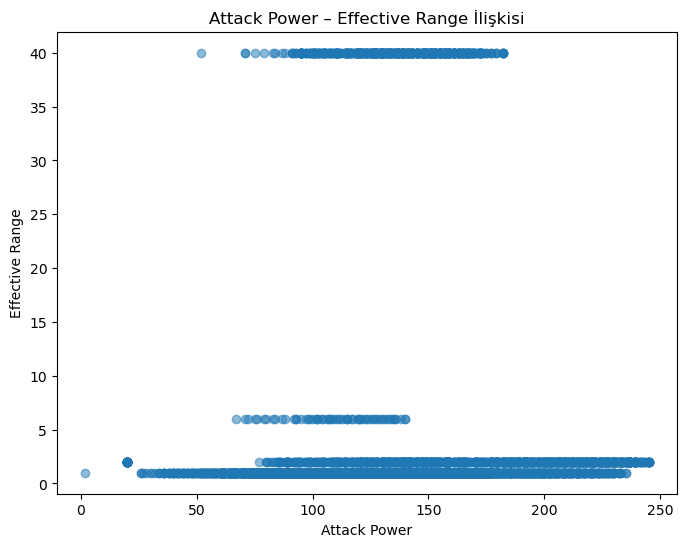

In [ ]:


plt.figure(figsize=(8, 6))
plt.scatter(
    items_analysis_df["Attack Power"],
    items_analysis_df["Effective Range"],
    alpha=0.5
)
plt.title("Attack Power – Effective Range İlişkisi")
plt.xlabel("Attack Power")
plt.ylabel("Effective Range")
plt.show()


In [ ]:
# weight başına güç oranı
items_analysis_df["Power_per_Weight"] = (
    items_analysis_df["Attack Power"] / items_analysis_df["Weight"]
)

# En verimli 10 silah (bu veri oyun için bir şey ifade etmiyor. Sadece Kilo ve Attak Power arasındaki ilişkiye bakmak istedim.)
top_efficiency = items_analysis_df.sort_values(
    "Power_per_Weight", ascending=False
).head(10)[["name", "Attack Power", "Weight", "Power_per_Weight"]]

print("En Verimli 10 Silah (Kilo Başına Güç):")
print(top_efficiency)


En Verimli 10 Silah (Kilo Başına Güç):
                            name  Attack Power  Weight  Power_per_Weight
11796  Hepa's Bone Crasher (+21)         140.0     1.0             140.0
11428  Hepa's Bone Crasher (+10)         140.0     1.0             140.0
11795  Hepa's Bone Crasher (+20)         138.0     1.0             138.0
11794  Hepa's Bone Crasher (+19)         136.0     1.0             136.0
11111         Bone Crasher (+21)         135.0     1.0             135.0
11090         Bone Crasher (+10)         135.0     1.0             135.0
11793  Hepa's Bone Crasher (+18)         134.0     1.0             134.0
11110         Bone Crasher (+20)         133.0     1.0             133.0
11792  Hepa's Bone Crasher (+17)         132.0     1.0             132.0
11109         Bone Crasher (+19)         131.0     1.0             131.0


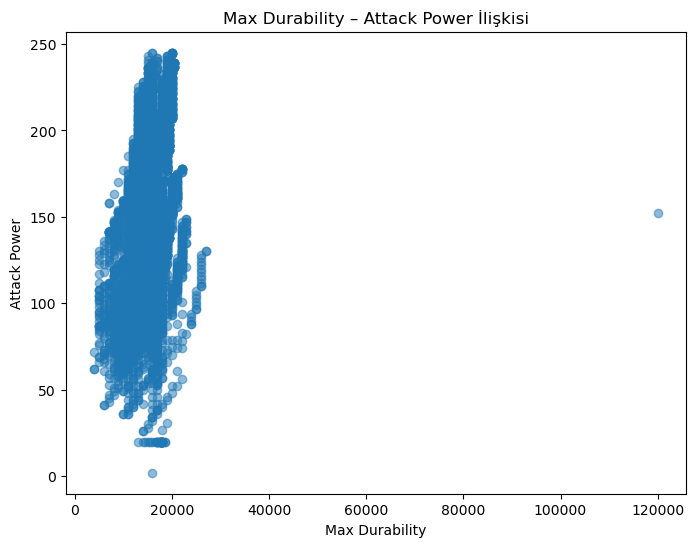

In [ ]:
#dayanlıklılık Hasar ilişikisi (yine oyun için bir şey ifade etmiyor)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    items_analysis_df["Max Durability"],
    items_analysis_df["Attack Power"],
    alpha=0.5
)
plt.title("Max Durability – Attack Power İlişkisi")
plt.xlabel("Max Durability")
plt.ylabel("Attack Power")
plt.show()


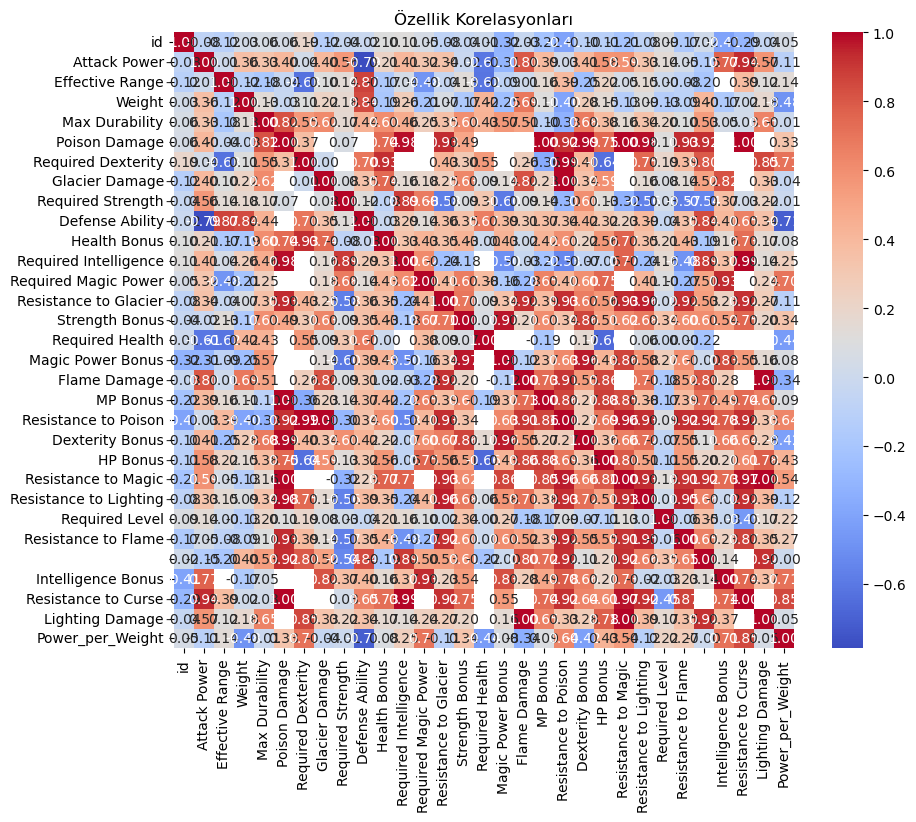

In [ ]:
#Özellik Korelasyonu (heatmap)

import seaborn as sns

# Sadece sayısal veri olan sütunları seçiyoruz
numeric_df = items_analysis_df.select_dtypes(include=["number"])

plt.figure(figsize=(10, 8))
sns.heatmap(
    numeric_df.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Özellik Korelasyonları")
plt.show()


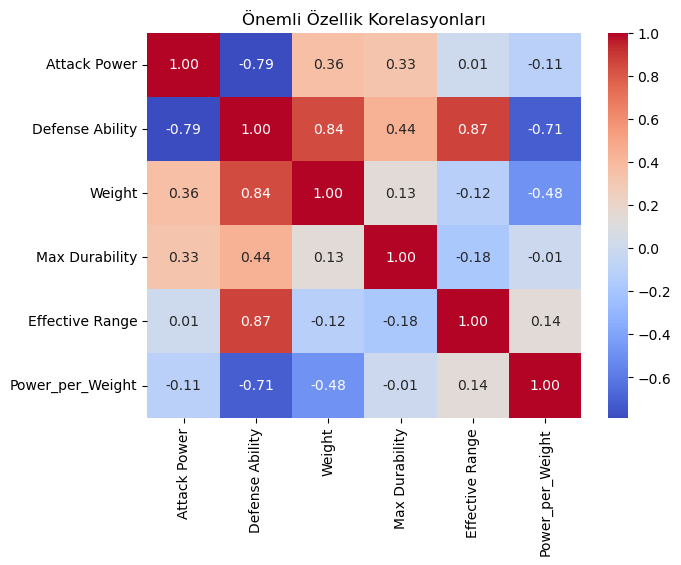

In [ ]:
key_cols = [
    "Attack Power",
    "Defense Ability",
    "Weight",
    "Max Durability",
    "Effective Range",
    "Power_per_Weight"
]

plt.figure(figsize=(7,5))
sns.heatmap(
    items_analysis_df[key_cols].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Önemli Özellik Korelasyonları")
plt.show()


In [ ]:
# 1. En yüksek saldırı gücüne sahip 10 item
top_attack = items_analysis_df.sort_values(by="Attack Power", ascending=False).head(10)
print("En yüksek saldırı gücüne sahip 10 item:")
print(top_attack[["name", "class", "Attack Power", "Weight"]])

# 2. En yüksek savunma gücüne sahip 10 item
top_defense = items_analysis_df.sort_values(by="Defense Ability", ascending=False).head(10)
print("\nEn yüksek savunma gücüne sahip 10 item:")
print(top_defense[["name", "class", "Defense Ability", "Weight"]])

# 3. En hafif ama en güçlü silahlar (Power_per_Weight oranına göre)
top_efficiency = items_analysis_df.sort_values(by="Power_per_Weight", ascending=False).head(10)
print("\nEn hafif ama en güçlü silahlar (Power_per_Weight):")
print(top_efficiency[["name", "class", "Attack Power", "Weight", "Power_per_Weight"]])


En yüksek saldırı gücüne sahip 10 item:
                                     name    class  Attack Power  Weight
7744                Dark Knight Axe (+10)   Kurian         245.0     4.0
12883  Golden Dragon Crescent Blade (+10)  Warrior         245.0    15.0
7765                Dark Knight Axe (+21)   Kurian         245.0     4.0
7602              Dark Knight Spear (+21)  Warrior         245.0    15.0
12904  Golden Dragon Crescent Blade (+21)  Warrior         245.0    15.0
7582              Dark Knight Spear (+10)  Warrior         245.0    15.0
14254     itemAnaliz's Buju Polearm (+21)  Warrior         245.0    15.0
14233     itemAnaliz's Buju Polearm (+10)  Warrior         245.0    15.0
9369                           Buju (+21)  Warrior         244.0    15.0
9347                           Buju (+10)  Warrior         244.0    15.0

En yüksek savunma gücüne sahip 10 item:
                           name    class  Defense Ability  Weight
14414  itemAnaliz's Adaga (+21)  Warrior          